# Model 5 - kNNRegressor with standardization & ln transformation

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import math
import os

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, r2_score

from openpyxl import load_workbook

In [2]:
# get data
parentdir = os.path.dirname(os.getcwd())
data = pd.read_excel(parentdir+'\\Data\\SWedge Results.xlsx',sheet_name = "Probabilistic Values", engine='openpyxl')
data.head()

,Wedge ID,Safety Factor,Ln Safety Factor,Safety Factor Class,Safety Factor Class_1,Safety Factor Class_2,Wedge Volume (m3),Wedge Weight (MN),Plunge Line of Intersection (°),Trend Line of Intersection (°),...,Water Pressure Joint 2 (MPa),Water Pressure Basal Joint (MPa),Water Pressure Tension Crack (MPa),Ponded Water Depth (m),Seismic Alpha,Seismic Plunge (°),Seismic Trend (°),Maximum Persistence Joint 1 (m),Maximum Persistence Joint 2 (m),Maximum Persistence Basal Joint (m)
0,BFA 60 [0],1.082239,0.079032,11.0,6.0,1.05,6349.248707,171.429715,31.846178,161.418240,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
1,BFA 60 [1],1.203906,0.185571,13.0,7.0,1.35,7701.148241,207.931003,31.905513,168.542870,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
2,BFA 60 [2],0.896601,-0.109144,9.0,5.0,0.75,2341.641868,63.224330,36.973415,150.874977,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
3,BFA 60 [3],0.680996,-0.384199,7.0,4.0,0.75,155.345062,4.194317,54.969435,195.219985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN
4,BFA 60 [4],1.263948,0.234240,13.0,7.0,1.35,7468.340623,201.645197,29.688564,178.765625,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN


In [3]:
print(np.shape(data))

(5000, 91)


In [4]:
# get data specifically for the modelling (i.e., the inputs and output)
data_model = data[["Ln Safety Factor","Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
print(np.shape(data_model))
data_model.head()

(5000, 9)


,Ln Safety Factor,Dip of Joint 1 (°),Dip Direction of Joint 1 (°),Dip of Joint 2 (°),Dip Direction of Joint 2 (°),Dip of Slope (°),Dip Direction of Slope (°),Friction Angle of Joint 1 (°),Friction Angle of Joint 2 (°)
0,0.079032,39.265808,120.865923,51.646228,221.979277,58.840543,182.626968,29.567773,29.522638
1,0.185571,38.981309,128.836961,57.766382,235.428421,63.804918,181.820235,32.713619,29.079492
2,-0.109144,42.032968,117.504566,62.427355,217.726775,58.134485,180.398207,29.660213,27.455866
3,-0.384199,69.264568,137.906910,66.183726,246.195109,61.968796,182.439496,30.866657,34.401616
4,0.234240,46.728166,121.226945,50.803809,241.060589,60.832522,179.091174,28.789453,28.613525


In [5]:
# remove any realizations that are not kinematically possible and any duplicates
data_model =  data_model.dropna()
data_model = data_model.drop_duplicates()
print(np.shape(data_model))

(4992, 9)


## Learning curves for different train_test_split random_states

Variable random_state (=0, 1, 42, 123) for train_test_split.

In [6]:
num_samples = []

# r2 and rmse for ln(safety factor) - before undoing ln transformation
r2_train_subsample_list = []
rmse_train_subsample_list = []
r2_test_subsample_list = []
rmse_test_subsample_list = []

# r2 and rmse for safety factor after undoing ln transformation
r2_train_subsample_orig_list = []
rmse_train_subsample_orig_list = []
r2_test_subsample_orig_list = []
rmse_test_subsample_orig_list = []

random_state_val = [0,1,42,123]

for x in range(0,4):

    # dataset up to 4950 data points
    for i in range(100, 5000, 50):

        num_samples.append(i)

        # get subsample of data
        data_subsample = data_model.sample(n = i,random_state = 1)

        # train/test split with different random_state values (0, 1, 42, and 123)
        train_subsample, test_subsample = train_test_split(data_subsample, test_size=0.2, random_state=random_state_val[x])

        x_train_subsample = train_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
        y_train_subsample = train_subsample[["Ln Safety Factor"]]
        y_train_subsample = np.ravel(y_train_subsample)
        
        x_test_subsample = test_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
        y_test_subsample = test_subsample[["Ln Safety Factor"]]
        y_test_subsample = np.ravel(y_test_subsample)

        # train basic knn model with default hyperparameters on ln transformed safety factor
        # make pipeline for knn with pre-processing (standardizing the data)
        pipe_knn = make_pipeline(StandardScaler(), KNeighborsRegressor())
        pipe_knn.fit(x_train_subsample, y_train_subsample)

        ypred_knn = pipe_knn.predict(x_train_subsample)
        ypred_knn = np.reshape(ypred_knn,(len(ypred_knn),1))
        
        # undo ln transformation
        ypred_knn_orig = np.exp(ypred_knn)

        # training r2 and rmse before undoing ln transformation
        r2_train_subsample = pipe_knn.score(x_train_subsample,y_train_subsample)
        rmse_train_subsample = math.sqrt(mean_squared_error(y_train_subsample,ypred_knn))
        
        # training r2 and rmse after undoing ln transformation
        r2_train_subsample_orig = r2_score(np.exp(y_train_subsample),ypred_knn_orig)
        rmse_train_subsample_orig = math.sqrt(mean_squared_error(np.exp(y_train_subsample),ypred_knn_orig))

        # append training r2 and rmse to their respective lists
        r2_train_subsample_list.append(r2_train_subsample)
        rmse_train_subsample_list.append(rmse_train_subsample)
        r2_train_subsample_orig_list.append(r2_train_subsample_orig)
        rmse_train_subsample_orig_list.append(rmse_train_subsample_orig)
       
        # test the knn model
        # predict y test
        ypred_test_knn = pipe_knn.predict(x_test_subsample)
        ypred_test_knn = np.reshape(ypred_test_knn,(len(ypred_test_knn),1))
        
        # undo ln transformation
        ypred_test_knn_orig = np.exp(ypred_test_knn)

        # test r2 and rmse before undoing ln transformation
        r2_test_subsample = pipe_knn.score(x_test_subsample,y_test_subsample)
        rmse_test_subsample = math.sqrt(mean_squared_error(y_test_subsample,ypred_test_knn))
        
        # test r2 and rmse after undoing ln transformation
        r2_test_subsample_orig = r2_score(np.exp(y_test_subsample),ypred_test_knn_orig)
        rmse_test_subsample_orig = math.sqrt(mean_squared_error(np.exp(y_test_subsample),ypred_test_knn_orig))

        # append testing r2 and rmse to their respective lists
        r2_test_subsample_list.append(r2_test_subsample)
        rmse_test_subsample_list.append(rmse_test_subsample)
        r2_test_subsample_orig_list.append(r2_test_subsample_orig)
        rmse_test_subsample_orig_list.append(rmse_test_subsample_orig)
    
    # entire dataset (4992 data points)
    num_samples.append(len(data_model.index))

    # get subsample of data
    data_subsample = data_model.sample(n = len(data_model.index),random_state = 1)

    # train/test split with different random_state values (0, 1, 42, and 123)
    train_subsample, test_subsample = train_test_split(data_subsample, test_size=0.2, random_state=random_state_val[x])

    x_train_subsample = train_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
    y_train_subsample = train_subsample[["Ln Safety Factor"]]
    y_train_subsample = np.ravel(y_train_subsample)

    x_test_subsample = test_subsample[["Dip of Joint 1 (°)","Dip Direction of Joint 1 (°)","Dip of Joint 2 (°)","Dip Direction of Joint 2 (°)","Dip of Slope (°)","Dip Direction of Slope (°)","Friction Angle of Joint 1 (°)","Friction Angle of Joint 2 (°)"]]
    y_test_subsample = test_subsample[["Ln Safety Factor"]]
    y_test_subsample = np.ravel(y_test_subsample)

    # train basic knn model with default hyperparameters on ln transformed safety factor
    # make pipeline for knn with pre-processing (standardizing the data)
    pipe_knn = make_pipeline(StandardScaler(), KNeighborsRegressor())
    pipe_knn.fit(x_train_subsample, y_train_subsample)

    ypred_knn = pipe_knn.predict(x_train_subsample)
    ypred_knn = np.reshape(ypred_knn,(len(ypred_knn),1))

    # undo ln transformation
    ypred_knn_orig = np.exp(ypred_knn)

    # training r2 and rmse before undoing ln transformation
    r2_train_subsample = pipe_knn.score(x_train_subsample,y_train_subsample)
    rmse_train_subsample = math.sqrt(mean_squared_error(y_train_subsample,ypred_knn))

    # training r2 and rmse after undoing ln transformation
    r2_train_subsample_orig = r2_score(np.exp(y_train_subsample),ypred_knn_orig)
    rmse_train_subsample_orig = math.sqrt(mean_squared_error(np.exp(y_train_subsample),ypred_knn_orig))

    # append training r2 and rmse to their respective lists
    r2_train_subsample_list.append(r2_train_subsample)
    rmse_train_subsample_list.append(rmse_train_subsample)
    r2_train_subsample_orig_list.append(r2_train_subsample_orig)
    rmse_train_subsample_orig_list.append(rmse_train_subsample_orig)

    # test the knn model
    # predict y test
    ypred_test_knn = pipe_knn.predict(x_test_subsample)
    ypred_test_knn = np.reshape(ypred_test_knn,(len(ypred_test_knn),1))

    # undo ln transformation
    ypred_test_knn_orig = np.exp(ypred_test_knn)

    # test r2 and rmse before undoing ln transformation
    r2_test_subsample = pipe_knn.score(x_test_subsample,y_test_subsample)
    rmse_test_subsample = math.sqrt(mean_squared_error(y_test_subsample,ypred_test_knn))

    # test r2 and rmse after undoing ln transformation
    r2_test_subsample_orig = r2_score(np.exp(y_test_subsample),ypred_test_knn_orig)
    rmse_test_subsample_orig = math.sqrt(mean_squared_error(np.exp(y_test_subsample),ypred_test_knn_orig))

    # append test r2 and rmse to their respective lists
    r2_test_subsample_list.append(r2_test_subsample)
    rmse_test_subsample_list.append(rmse_test_subsample)
    r2_test_subsample_orig_list.append(r2_test_subsample_orig)
    rmse_test_subsample_orig_list.append(rmse_test_subsample_orig)
    

In [7]:
# transform lists of results into dataframes
num_samples = pd.DataFrame(num_samples)

r2_train_subsample_list = pd.DataFrame(r2_train_subsample_list)
rmse_train_subsample_list = pd.DataFrame(rmse_train_subsample_list)
r2_train_subsample_orig_list = pd.DataFrame(r2_train_subsample_orig_list)
rmse_train_subsample_orig_list = pd.DataFrame(rmse_train_subsample_orig_list)

r2_test_subsample_list = pd.DataFrame(r2_test_subsample_list)
rmse_test_subsample_list = pd.DataFrame(rmse_test_subsample_list)
r2_test_subsample_orig_list = pd.DataFrame(r2_test_subsample_orig_list)
rmse_test_subsample_orig_list = pd.DataFrame(rmse_test_subsample_orig_list)

In [9]:
# concatenate dataframes into one result dataframe
rslts = pd.concat([num_samples,r2_train_subsample_list,rmse_train_subsample_list,r2_train_subsample_orig_list,rmse_train_subsample_orig_list,r2_test_subsample_list,rmse_test_subsample_list,r2_test_subsample_orig_list,rmse_test_subsample_orig_list],axis=1)

In [10]:
# divide the rslts dataframe by the random_state value
random_state_len = int(max(np.shape(rslts))/len(random_state_val))
randomstate0_rslts = rslts[0:random_state_len]
randomstate1_rslts = rslts[random_state_len:2*random_state_len]
randomstate42_rslts = rslts[2*random_state_len:3*random_state_len]
randomstate123_rslts = rslts[3*random_state_len:4*random_state_len]

randomstate123_rslts.tail()

,0,0,0,0,0,0,0,0,0
391,4800,0.915446,0.101314,0.772176,0.256206,0.882536,0.113247,0.829406,0.174906
392,4850,0.918556,0.099263,0.805506,0.230471,0.861172,0.125194,0.619239,0.305344
393,4900,0.915667,0.100352,0.802982,0.226495,0.860129,0.128565,0.611913,0.334839
394,4950,0.914163,0.101485,0.769847,0.250114,0.868456,0.122793,0.739508,0.247921
395,4992,0.914652,0.101446,0.772609,0.252240,0.884665,0.114208,0.809129,0.199795


In [11]:
randomstate0_rslts_np = np.asarray(randomstate0_rslts)
randomstate1_rslts_np = np.asarray(randomstate1_rslts)
randomstate42_rslts_np = np.asarray(randomstate42_rslts)
randomstate123_rslts_np = np.asarray(randomstate123_rslts)


randomstate0_rslts_pd = pd.DataFrame(randomstate0_rslts_np,columns=['num_samples','R2_train_subsample','rmse_train_subsample','R2_train_subsample_orig','rmse_train_subsample_orig','R2_test_subsample','rmse_test_subsample','R2_test_subsample_orig','rmse_test_subsample_orig'])
randomstate1_rslts_pd = pd.DataFrame(randomstate1_rslts_np,columns=['num_samples','R2_train_subsample','rmse_train_subsample','R2_train_subsample_orig','rmse_train_subsample_orig','R2_test_subsample','rmse_test_subsample','R2_test_subsample_orig','rmse_test_subsample_orig'])
randomstate42_rslts_pd = pd.DataFrame(randomstate42_rslts_np,columns=['num_samples','R2_train_subsample','rmse_train_subsample','R2_train_subsample_orig','rmse_train_subsample_orig','R2_test_subsample','rmse_test_subsample','R2_test_subsample_orig','rmse_test_subsample_orig'])
randomstate123_rslts_pd = pd.DataFrame(randomstate123_rslts_np,columns=['num_samples','R2_train_subsample','rmse_train_subsample','R2_train_subsample_orig','rmse_train_subsample_orig','R2_test_subsample','rmse_test_subsample','R2_test_subsample_orig','rmse_test_subsample_orig'])


In [12]:
# specify a font for all of the graphs/figures in this Jupyter Notebook
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

(0.0, 1.0)

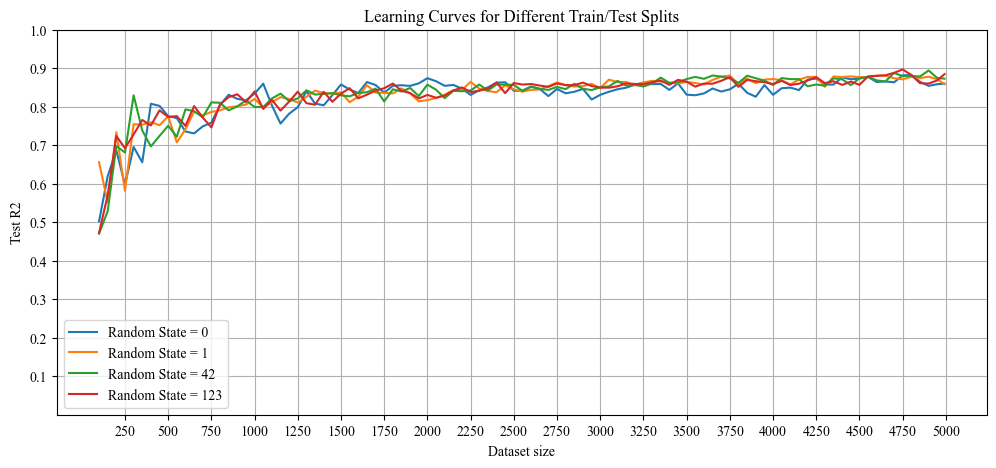

In [13]:
# plot learning curves for different train/test splits for test R2
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['R2_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['R2_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['R2_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['R2_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test R2')
plt.legend()
plt.grid()
plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])
plt.ylim(0,1)

([<matplotlib.axis.XTick at 0x226cb8c0610>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

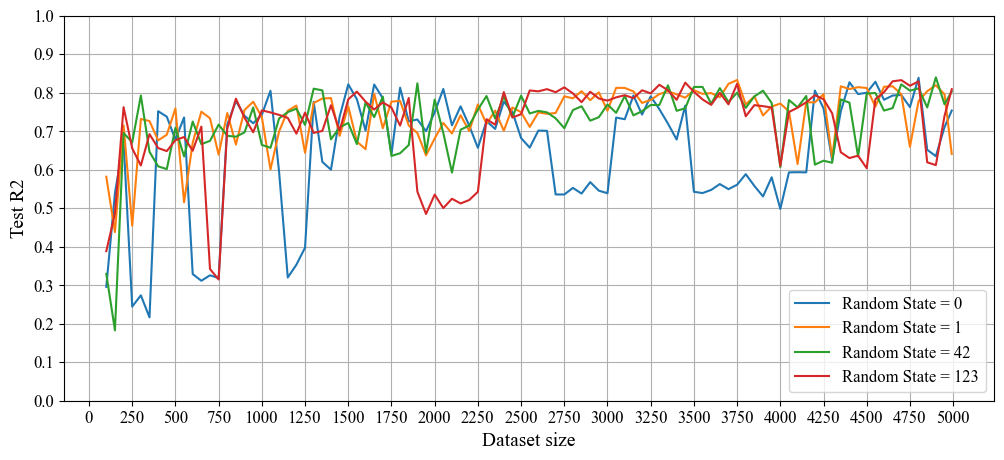

In [14]:
# plot learning curves for different train/test splits for test R2 (orig - after undoing ln transformation)
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['R2_test_subsample_orig'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['R2_test_subsample_orig'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['R2_test_subsample_orig'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['R2_test_subsample_orig'],label='Random State = 123')
#plt.title('Learning Curves for Different Train/Test Splits (Untransformed Data)')
plt.xlabel('Dataset size',fontsize=14)
plt.ylabel('Test R2',fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.yticks(ticks=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],fontsize=12)
plt.xticks(ticks=[0,250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000],fontsize=12)
#plt.ylim(0,1)

([<matplotlib.axis.XTick at 0x226cb96fc40>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

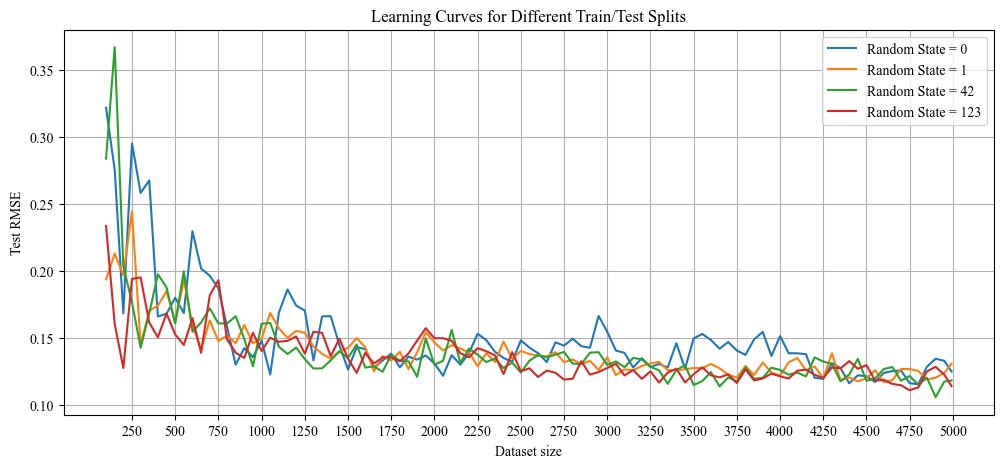

In [15]:
# plot learning curves for different train/test splits for test rmse
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['rmse_test_subsample'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['rmse_test_subsample'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['rmse_test_subsample'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['rmse_test_subsample'],label='Random State = 123')
plt.title('Learning Curves for Different Train/Test Splits')
plt.xlabel('Dataset size')
plt.ylabel('Test RMSE')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x226cb8e9eb0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

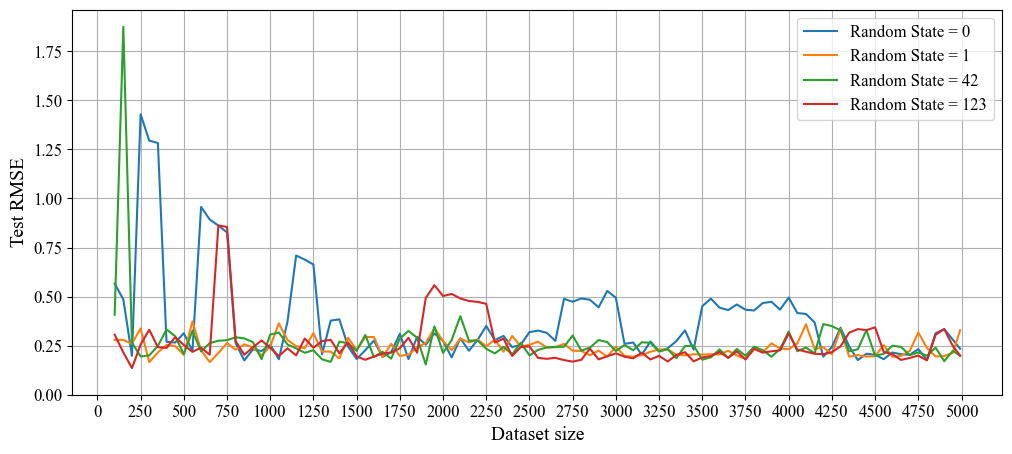

In [16]:
# plot learning curves for different train/test splits for test rmse (after undoing ln transformation)
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rslts_pd['rmse_test_subsample_orig'],label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rslts_pd['rmse_test_subsample_orig'],label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rslts_pd['rmse_test_subsample_orig'],label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rslts_pd['rmse_test_subsample_orig'],label='Random State = 123')
#plt.title('Learning Curves for Different Train/Test Splits (Untransformed Data)')
plt.xlabel('Dataset size',fontsize=14)
plt.ylabel('Test RMSE',fontsize=14)
plt.legend(fontsize=12)
plt.grid()
plt.ylim(bottom=0)
plt.yticks(fontsize=12)
plt.xticks(ticks=[0,250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000],fontsize=12)

In [17]:
# train R2 - test R2
randomstate0_R2diff = randomstate0_rslts_pd['R2_train_subsample'] - randomstate0_rslts_pd['R2_test_subsample']
randomstate1_R2diff = randomstate1_rslts_pd['R2_train_subsample'] - randomstate1_rslts_pd['R2_test_subsample']
randomstate42_R2diff = randomstate42_rslts_pd['R2_train_subsample'] - randomstate42_rslts_pd['R2_test_subsample']
randomstate123_R2diff = randomstate123_rslts_pd['R2_train_subsample'] - randomstate123_rslts_pd['R2_test_subsample']

# test RMSE - train RMSE
randomstate0_rmsediff = randomstate0_rslts_pd['rmse_test_subsample'] - randomstate0_rslts_pd['rmse_train_subsample']
randomstate1_rmsediff = randomstate1_rslts_pd['rmse_test_subsample'] - randomstate1_rslts_pd['rmse_train_subsample']
randomstate42_rmsediff = randomstate42_rslts_pd['rmse_test_subsample'] - randomstate42_rslts_pd['rmse_train_subsample']
randomstate123_rmsediff = randomstate123_rslts_pd['rmse_test_subsample'] - randomstate123_rslts_pd['rmse_train_subsample']



In [18]:
# train R2 - test R2 (after undoing ln transformation)
randomstate0_R2origdiff = randomstate0_rslts_pd['R2_train_subsample_orig'] - randomstate0_rslts_pd['R2_test_subsample_orig']
randomstate1_R2origdiff = randomstate1_rslts_pd['R2_train_subsample_orig'] - randomstate1_rslts_pd['R2_test_subsample_orig']
randomstate42_R2origdiff = randomstate42_rslts_pd['R2_train_subsample_orig'] - randomstate42_rslts_pd['R2_test_subsample_orig']
randomstate123_R2origdiff = randomstate123_rslts_pd['R2_train_subsample_orig'] - randomstate123_rslts_pd['R2_test_subsample_orig']

# test RMSE - train RMSE (after undoing ln transformation)
randomstate0_rmseorigdiff = randomstate0_rslts_pd['rmse_test_subsample_orig'] - randomstate0_rslts_pd['rmse_train_subsample_orig']
randomstate1_rmseorigdiff = randomstate1_rslts_pd['rmse_test_subsample_orig'] - randomstate1_rslts_pd['rmse_train_subsample_orig']
randomstate42_rmseorigdiff = randomstate42_rslts_pd['rmse_test_subsample_orig'] - randomstate42_rslts_pd['rmse_train_subsample_orig']
randomstate123_rmseorigdiff = randomstate123_rslts_pd['rmse_test_subsample_orig'] - randomstate123_rslts_pd['rmse_train_subsample_orig']



([<matplotlib.axis.XTick at 0x226cbabab80>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

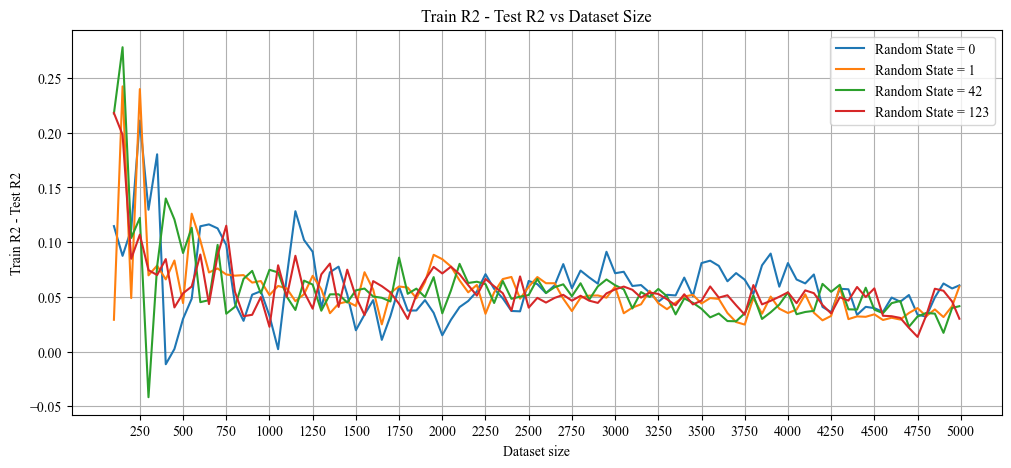

In [19]:
# plot R2 diff vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_R2diff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_R2diff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_R2diff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_R2diff,label='Random State = 123')
plt.title('Train R2 - Test R2 vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Train R2 - Test R2')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x226cb840700>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

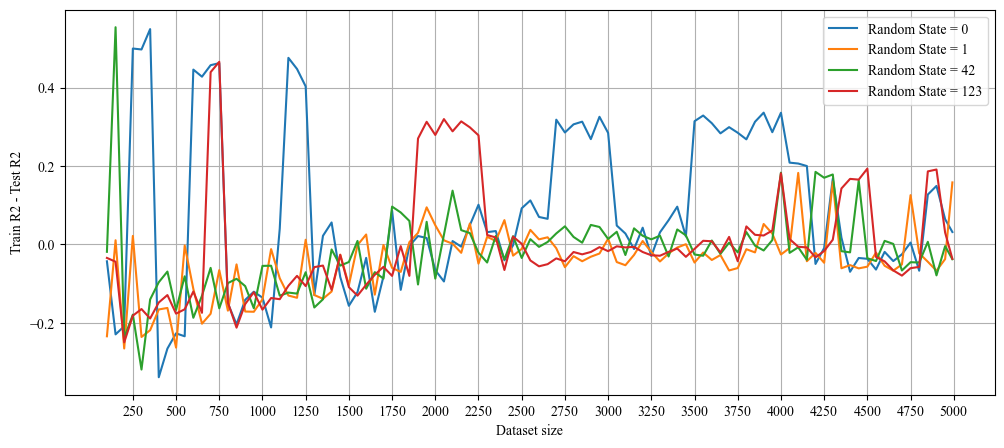

In [20]:
# plot R2 diff vs dataset size (after undoing ln transformation)
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_R2origdiff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_R2origdiff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_R2origdiff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_R2origdiff,label='Random State = 123')
#plt.title('Train R2 - Test R2 (Untransformed Data) vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Train R2 - Test R2')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x226cd1f86a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

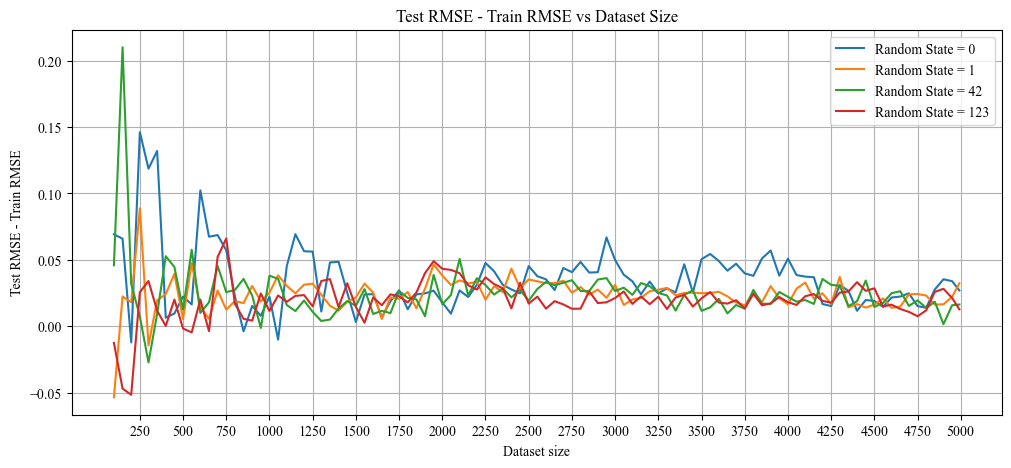

In [21]:
# plot rmse diff vs dataset size
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rmsediff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rmsediff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rmsediff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rmsediff,label='Random State = 123')
plt.title('Test RMSE - Train RMSE vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Test RMSE - Train RMSE')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

([<matplotlib.axis.XTick at 0x226cd2a9460>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

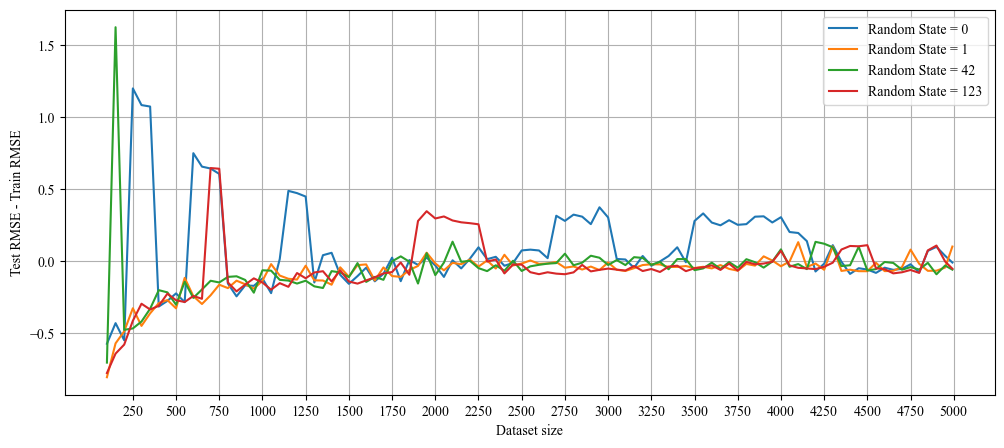

In [22]:
# plot rmse diff vs dataset size (after undoing ln transformation)
plt.figure(figsize=(12,5))
plt.plot(randomstate0_rslts_pd['num_samples'],randomstate0_rmseorigdiff,label='Random State = 0')
plt.plot(randomstate1_rslts_pd['num_samples'],randomstate1_rmseorigdiff,label='Random State = 1')
plt.plot(randomstate42_rslts_pd['num_samples'],randomstate42_rmseorigdiff,label='Random State = 42')
plt.plot(randomstate123_rslts_pd['num_samples'],randomstate123_rmseorigdiff,label='Random State = 123')
#plt.title('Test RMSE - Train RMSE (Untransformed Data) vs Dataset Size')
plt.xlabel('Dataset size')
plt.ylabel('Test RMSE - Train RMSE')
plt.legend()
plt.grid()
#plt.yticks(ticks=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.xticks(ticks=[250,500,750,1000,1250,1500,1750,2000,2250,2500,2750,3000,3250,3500,3750,4000,4250,4500,4750,5000])

In [23]:
# concatenate results for each random_state value into one dataframe for output into Excel
rslts_formatted = pd.concat([randomstate0_rslts_pd,randomstate1_rslts_pd,randomstate42_rslts_pd,randomstate123_rslts_pd],axis=1)
rslts_formatted

,num_samples,R2_train_subsample,rmse_train_subsample,R2_train_subsample_orig,rmse_train_subsample_orig,R2_test_subsample,rmse_test_subsample,R2_test_subsample_orig,rmse_test_subsample_orig,num_samples,...,rmse_test_subsample_orig,num_samples,R2_train_subsample,rmse_train_subsample,R2_train_subsample_orig,rmse_train_subsample_orig,R2_test_subsample,rmse_test_subsample,R2_test_subsample_orig,rmse_test_subsample_orig
0,100.0,0.616751,0.252686,0.252828,1.139041,0.502122,0.321939,0.295727,0.566271,100.0,...,0.407252,100.0,0.690204,0.246160,0.354348,1.081907,0.472211,0.233653,0.388641,0.305923
1,150.0,0.707138,0.209909,0.309777,0.915921,0.619685,0.275832,0.538944,0.485981,150.0,...,1.875048,150.0,0.768510,0.207526,0.442301,0.856957,0.570422,0.160640,0.486260,0.215613
2,200.0,0.797793,0.180618,0.465403,0.746990,0.686239,0.168475,0.673927,0.198038,200.0,...,0.265550,200.0,0.808678,0.179198,0.512918,0.714255,0.723910,0.127667,0.762393,0.135586
3,250.0,0.808751,0.149333,0.743955,0.230607,0.597658,0.295480,0.244493,1.429128,250.0,...,0.195053,250.0,0.799077,0.168614,0.473725,0.668505,0.692248,0.194240,0.655270,0.255192
4,300.0,0.825187,0.139769,0.770782,0.211981,0.695584,0.258413,0.273744,1.294830,300.0,...,0.200368,300.0,0.802345,0.161248,0.446485,0.626168,0.727943,0.195351,0.611118,0.330929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,4800.0,0.914314,0.101560,0.771950,0.254715,0.882419,0.115544,0.838877,0.177063,4800.0,...,0.198729,4800.0,0.915446,0.101314,0.772176,0.256206,0.882536,0.113247,0.829406,0.174906
95,4850.0,0.914101,0.100950,0.779097,0.241515,0.864685,0.128702,0.651777,0.313072,4850.0,...,0.240356,4850.0,0.918556,0.099263,0.805506,0.230471,0.861172,0.125194,0.619239,0.305344
96,4900.0,0.916481,0.099190,0.784377,0.234885,0.854293,0.134600,0.635164,0.334281,4900.0,...,0.170850,4900.0,0.915667,0.100352,0.802982,0.226495,0.860129,0.128565,0.611913,0.334839
97,4950.0,0.916096,0.099139,0.775041,0.243035,0.858464,0.133095,0.710589,0.280295,4950.0,...,0.224009,4950.0,0.914163,0.101485,0.769847,0.250114,0.868456,0.122793,0.739508,0.247921


In [24]:
# output results to Excel
book = load_workbook(parentdir+'\\ML Models Results\\Model5_Results.xlsx')
writer = pd.ExcelWriter(parentdir+'\\ML Models Results\\Model5_Results.xlsx', engine='openpyxl') 
writer.book = book
writer.sheets = dict((ws.title, ws) for ws in book.worksheets)
rslts_formatted.to_excel(writer, 'FORMATTED')
writer.save()
writer.close()